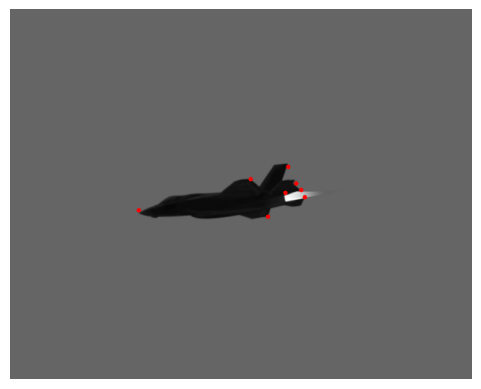

In [5]:
# 2024年3月24日，生成姿态生成核心代码
# 输入给定的姿态
# 输出对应的飞机图片，以及对应的关键点标签信息
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

class Tracklet_generation:
    def __init__(self, raw_data_path, multi = 1):
        """
        初始化函数，设置计算器的初始值。
        
        参数:
            initial_value (int, 可选): 计算器的初始值，默认为0。
            multi 代表两种数据集，一种是单波段的，一种是多波段的，分别是0和1表示
        """
        # 关键点的深度值，根据不同目标去修改
        self.DEP = np.array([-0.02, -0.02, -0.02, 0.05, -0.01, 0.05, -0.02, -0.02])
        # 相机内参矩阵示例
        self.depth = 50
        fx = 20000  # 假设焦距为512/27 pix/m
        fy = 20000  # 假设焦距为512/27 pix/m
        if multi == 0:
            cx, cy = 330, 258  # 假设图像中心为原点（根据实际情况调整）#329.3  258.8
        else:
            cx, cy = 318, 256
        self.K = np.array([
            [fx, 0, cx],
            [0, fy, cy],
            [0, 0, 1]
        ])
        self.K_inv = np.array([
            [1/fx, 0, -cx/fx], 
            [0, 1/fy, -cy/fy],
            [0, 0, 1]
        ])

        '''初始点位置'''
        # raw_data_path = D:\\funding\\No17\\middle\\data\\MB1
        self.raw_data_path = raw_data_path
        raw = raw_data_path + '\\label_initial_frame\\pitch0_yaw0.json' #'D:\\funding\\No17\\middle\\data\\labels\\kpimgs\\俯仰角0_方位角0.json'
        json_path = raw
            
        # 读取并解析JSON文件，指定编码为UTF-8
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        # 按照label排序并提取关键点
        shapes = sorted(data['shapes'], key=lambda x: int(x['label']))
        self.points_init = [shape['points'][0] for shape in shapes]
        # self.folder = 'D:\\funding\\No17\\middle\\data\\SortedImages\\pitch'
        #self.points_init = self.rotate_only_keypoints(self.points_init, np.array([330,259]), -90)
    def euler_to_rot_matrix(self,yaw, pitch, roll):
        # 将角度转换为弧度
        yaw_rad = np.deg2rad(yaw)
        pitch_rad = np.deg2rad(pitch)
        # 计算旋转矩阵
        R_pitch = np.array([
            [np.cos(pitch_rad), 0, np.sin(pitch_rad)],
            [0, 1, 0],
            [-np.sin(pitch_rad), 0, np.cos(pitch_rad)]
        ])
        
        # 绕z轴旋转的矩阵（方位角）
        R_yaw = np.array([
            [np.cos(yaw_rad), -np.sin(yaw_rad), 0],
            [np.sin(yaw_rad), np.cos(yaw_rad), 0],
            [0, 0, 1]
        ])
    
        # Combined rotation matrix
        R = np.dot(R_pitch,R_yaw)
        return R
        
    def euler_to_rot_matrix_multi(self, yaw, pitch, roll):
        # 将角度转换为弧度
        yaw_rad = np.deg2rad(yaw)
        pitch_rad = np.deg2rad(pitch)
        # 计算旋转矩阵
        # R_pitch = np.array([
        #     [np.cos(pitch_rad), 0, np.sin(pitch_rad)],
        #     [0, 1, 0],
        #     [-np.sin(pitch_rad), 0, np.cos(pitch_rad)]
        # ])
        R_pitch = np.array([
        [1, 0, 0],
        [0, np.cos(pitch_rad), -np.sin(pitch_rad)],
        [0, np.sin(pitch_rad), np.cos(pitch_rad)]
        ])
        # 绕z轴旋转的矩阵（方位角）
        R_yaw = np.array([
            [np.cos(yaw_rad), -np.sin(yaw_rad), 0],
            [np.sin(yaw_rad), np.cos(yaw_rad), 0],
            [0, 0, 1]
        ])
    
        # Combined rotation matrix
        R = np.dot(R_pitch,R_yaw)
        return R

    
    # def point_rotataion(self,points_init,pitch, yaw):
    #     def project_2d_to_3d(points_2d, K_inv, depth):
    #         """将2D点投影到3D空间中，假设所有点在同一深度"""
    #         # 转换为齐次坐标
    #         kk = np.ones((points_2d.shape[0], 1))
    #         points_hom = np.hstack([points_2d, kk])
    #         # 通过相机内参逆矩阵投影到3D
    #         points_3d = (K_inv @ points_hom.T).T
    #         # points_3d[:, -1] = depth*points_3d[:, -1]
    #         return points_3d[:, :3]
        
    #     def rotate_points_3d(points_3d, R):
    #         """应用3D旋转"""
    #         return (R @ points_3d.T).T
        
    #     def project_3d_to_2d(points_3d, K):
    #         """将3D点投影回2D图像平面"""
    #         # 将3D点转换为齐次坐标
    #         # 使用K矩阵将3D点投影到2D，注意这里直接使用3D点的前3维进行投影
    #         points_2d = points_3d[:, :] / points_3d[:, [2]]
    #         points_2d = (K @ points_2d.T).T  # 注意这里改为使用 points_3d 而非 points_hom
    #         # 将齐次2D坐标转换为普通2D坐标
    #         return points_2d[:,:2]
    #     # 2D点坐标示例
    #     points_2d = np.array(points_init)
    #     points_3d = project_2d_to_3d(points_2d, self.K_inv, self.depth)
    #     rod = self.depth + np.array([-0.01, 0.0, 0.0, 0.100, -0.01, 0.100, 0.012, 0.012])
    #     # given the deth information
    #     for i in range(3): points_3d[:,i] = points_3d[:,i]*rod     
    #     #绕着 z轴旋转
    #     R = self.euler_to_rot_matrix(-yaw, 0, 0)
    #     points_3d_rotated = rotate_points_3d(points_3d, R)
        
    #     points_3d_rotated[:,-1] = points_3d_rotated[:,-1] - self.depth
    #     points_3d_rotated[:,0] = points_3d_rotated[:,0] + 0.02
    #     R = self.euler_to_rot_matrix(0, -pitch, 0)
    #     points_3d_rotated = rotate_points_3d(points_3d_rotated, R)  
    #     points_3d_rotated[:,-1] = points_3d_rotated[:,-1] + self.depth  
    #     points_3d_rotated[:,0] = points_3d_rotated[:,0] - 0.02
    #     points_2d_projected = project_3d_to_2d(points_3d_rotated, self.K)
    #     return points_2d_projected

    def point_rotataion_multi(self, points_init, pitch, yaw):
        def project_2d_to_3d(points_2d, K_inv, depth):
            """将2D点投影到3D空间中，假设所有点在同一深度"""
            # 转换为齐次坐标
            kk = np.ones((points_2d.shape[0], 1))
            points_hom = np.hstack([points_2d, kk])
            # 通过相机内参逆矩阵投影到3D
            points_3d = (K_inv @ points_hom.T).T
            # points_3d[:, -1] = depth*points_3d[:, -1]
            return points_3d[:, :3]
        
        def rotate_points_3d(points_3d, R):
            """应用3D旋转"""
            return (R @ points_3d.T).T
        
        def project_3d_to_2d(points_3d, K):
            """将3D点投影回2D图像平面"""
            # 将3D点转换为齐次坐标
            # 使用K矩阵将3D点投影到2D，注意这里直接使用3D点的前3维进行投影
            points_2d = points_3d[:, :] / points_3d[:, [2]]
            points_2d = (K @ points_2d.T).T  # 注意这里改为使用 points_3d 而非 points_hom
            # 将齐次2D坐标转换为普通2D坐标
            return points_2d[:,:2]
        # 2D点坐标示例
        points_2d = np.array(points_init)
        points_3d = project_2d_to_3d(points_2d, self.K_inv, self.depth)

        rod = self.depth + self.DEP #np.array([-0.02, -0.02, -0.02, 0.05, -0.01, 0.05, -0.02, -0.02])
        # rod = self.depth
        # given the deth information
        for i in range(3): points_3d[:,i] = points_3d[:,i]*rod     
        #绕着 z轴旋转
        R = self.euler_to_rot_matrix(yaw, 0, 0)
        points_3d_rotated = rotate_points_3d(points_3d, R)
        points_3d_rotated[:,-1] = points_3d_rotated[:,-1] - self.depth
        points_3d_rotated[:,0] = points_3d_rotated[:,0] + 0.02
        R = self.euler_to_rot_matrix_multi(0, pitch, 0)
        points_3d_rotated = rotate_points_3d(points_3d_rotated, R) 
        points_3d_rotated[:,-1] = points_3d_rotated[:,-1] + self.depth  
        points_3d_rotated[:,0] = points_3d_rotated[:,0] - 0.02
        points_2d_projected = project_3d_to_2d(points_3d_rotated, self.K)
        return points_2d_projected
    def rotate_only_keypoints(self, keypoints, ksize, angle):
        # Calculate the rotation matrix manually since we don't have an image
        image_center = (int(ksize[0]), int(ksize[1]))
        rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, scale=1)
        # 获取图像尺寸
        # Translate keypoints to origin based on the center point
        rotated_keypoints = []
        for point in keypoints:
            # 将关键点转换为齐次坐标
            original_point = np.array([point[0], point[1], 1])
            # 使用旋转矩阵计算旋转后的位置
            rotated_point = rotation_matrix @ original_point
            rotated_keypoints.append((rotated_point[0], rotated_point[1]))
        return rotated_keypoints
    def roll_image_and_keypoints(self, image, keypoints, angle):
        # 获取图像尺寸
        height, width = image.shape[:2]
        # 计算图像中心点
        image_center = (width / 2, height / 2)
        # 计算旋转矩阵
        rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, scale=1)
        # 旋转图像
        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height),borderMode=cv2.BORDER_REPLICATE)
        # 旋转关键点
        rotated_keypoints = []
        for point in keypoints:
            # 将关键点转换为齐次坐标
            original_point = np.array([point[0], point[1], 1])
            # 使用旋转矩阵计算旋转后的位置
            rotated_point = rotation_matrix @ original_point
            rotated_keypoints.append((rotated_point[0], rotated_point[1]))
        return rotated_image, rotated_keypoints
    def find_even(self,n):
        # 找到小于等于n的最大整数
        lower_int = math.floor(n)
        # 找到大于等于n的最小整数
        upper_int = math.ceil(n)
        
        # 确保lower_int是偶数，如果是奇数，则减1
        if lower_int % 2 != 0:
            lower_int -= 1
        
        # 确保upper_int是偶数，如果是奇数，则加1
        if upper_int % 2 != 0:
            upper_int += 1
        
        # 比较n与lower_int和upper_int的距离，返回更近的偶数
        if n - lower_int <= upper_int - n:
            return lower_int
        else:
            return upper_int
    def pitch_yaw_row_img(self, points_init, pitch, yaw, roll):
        '''rotation'''
        pitch,yaw,roll = 90+pitch, 180+yaw,-90+roll
        pitch,yaw,roll = self.find_even(pitch), self.find_even(yaw), self.find_even(roll)
        '''边界限定'''
        if pitch > 180: pitch = pitch - 180
        if pitch < 0: pitch = pitch + 180
        if yaw > 358: 
            yaw = yaw - 360
        raw = 'D:\\funding\\No17\\middle\\data\\SortedImages\\pitch' + str(pitch)
        folder_path = raw + '\pitch'+str(pitch)+'_yaw'+str(yaw)+'.png'
        image_path = folder_path
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        points_rotated = self.point_rotataion(points_init, pitch, yaw)
        image, keypoints = self.roll_image_and_keypoints(image, points_rotated, roll)
        return image, keypoints

    def pitch_yaw_row_img_multispec(self, points_init, pitch, yaw, roll):
        '''rotation'''
        pitch,yaw,roll = 90+pitch, 180-yaw, roll
        pitch,yaw,roll = int(pitch), int(yaw), int(roll)
        '''边界限定'''
        if pitch > 180: pitch = pitch - 180
        if pitch < 0: pitch = pitch + 180
        if yaw > 359: 
            yaw = yaw - 360
        # base = 'D:\\funding\\No17\\middle\\data\\SortedImages\\pitch'
        def read_img(base, pitch, yaw):
            raw = base + str(pitch)
            folder_path = raw + '\pitch'+str(pitch)+'_yaw'+str(yaw)+'.png'
            image_path = folder_path
            # print(folder_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            points_rotated = self.point_rotataion_multi(points_init, pitch, yaw)
            
            image, keypoints = self.roll_image_and_keypoints(image, points_rotated, roll)
            return image, keypoints
        swir_base = self.raw_data_path + '\\SWIR\\pitch'
        mwir_base = self.raw_data_path + '\\MWIR\\pitch'
        lwir_base = self.raw_data_path + '\\LWIR\\pitch'
        swir_img, keypoints = read_img(swir_base, pitch, yaw)
        mwir_img, _         = read_img(mwir_base, pitch, yaw)
        lwir_img, _         = read_img(lwir_base, pitch, yaw)
        return swir_img, mwir_img, lwir_img, keypoints
    def pose_img_kyp_generation(self,attitude):
        # 【0，1，0】先进行旋转，之后算出相机系下的旋转角度，还有相机系下的旋转向量
        # ，再根据旋转向量，得到对应的pitch和yaw的值，最后显示图片，并且旋转图片
        # 假设飞机的pitch,row,yaw分别是0，2，2
        def roll_image(image, angle):
            # 获取图像尺寸
            height, width = image.shape[:2]
            # 计算图像中心点
            image_center = (width / 2, height / 2)
            # 计算旋转矩阵
            rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, scale=1)
            # 旋转图像
            rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
            return rotated_image
        def rotate_vector(vector, angle_degrees, axis):
            rotation = R.from_euler(axis, angle_degrees, degrees=True)
            rotated_vector = rotation.apply(vector)
            return rotated_vector
        def rotate_vector_to_make_x_zero(x, vector, z):
            # 计算需要旋转的角度（弧度），使向量的 x 分量为 0
            angle_radians = np.arctan2(vector[1], vector[0])
            angle_degrees = np.degrees(angle_radians)
            # 创建绕 z 轴旋转的 Rotation 对象
            rotation = R.from_euler('z', 90-angle_degrees, degrees=True)
            # 应用旋转
            rotated_vector = rotation.apply(vector)
            rotated_vectorx = rotation.apply(x)
            rotated_vectorz = rotation.apply(z)
            return rotated_vectorx,rotated_vector,rotated_vectorz,  90-angle_degrees
        x = [1,0,0]
        y = [0,1,0]
        z = [0,0,1]

        rotation = R.from_euler('xyz', attitude, degrees=True)
        rotation = rotation.inv()
        x = rotation.apply(x)
        y = rotation.apply(y)
        z = rotation.apply(z)
        # 获取相机旋转，补偿滚转
        rotated_vectoryx, rotated_vectory, rotated_vectoryz, rotation_angle = rotate_vector_to_make_x_zero(x, y,z)
        def calculate_rotation_angles(a, b, c):
            rotation = R.align_vectors([a, b, c], [[1, 0, 0], [0, 1, 0],[0, 0, 1]])[0]
            rotation = rotation.inv()
            rotation_matrix = rotation.as_matrix()
            euler_angles = rotation.as_euler('xyz', degrees=True)
            angle_x, angle_y, angle_z = euler_angles
            return angle_x, angle_y
        angle_x, angle_y = calculate_rotation_angles(rotated_vectoryx, rotated_vectory,rotated_vectoryz)
        pitch = angle_x
        yaw   = angle_y
        roll  = rotation_angle
        '''消除超过90度的误差问题'''
        if pitch < -90 or pitch >90:
            pitch = pitch - np.sign(pitch)*180
            yaw = np.sign(yaw)*180 - yaw
        #image, kpts = self.pitch_yaw_row_img(self.points_init, pitch, yaw, roll)
        image, kpts = self.pitch_yaw_row_img(self.points_init, pitch, yaw, roll)
        return image, kpts
    def pose_img_kyp_generation_multispec(self, attitude):
        # 【0，1，0】先进行旋转，之后算出相机系下的旋转角度，还有相机系下的旋转向量
        # ，再根据旋转向量，得到对应的pitch和yaw的值，最后显示图片，并且旋转图片
        # 假设飞机的pitch,row,yaw分别是0，2，2
        def roll_image(image, angle):
            # 获取图像尺寸
            height, width = image.shape[:2]
            # 计算图像中心点
            image_center = (width / 2, height / 2)
            # 计算旋转矩阵
            rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, scale=1)
            # 旋转图像
            rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
            return rotated_image
        def rotate_vector(vector, angle_degrees, axis):
            rotation = R.from_euler(axis, angle_degrees, degrees=True)
            rotated_vector = rotation.apply(vector)
            return rotated_vector
        def rotate_vector_to_make_x_zero(x, vector, z):
            # 计算需要旋转的角度（弧度），使向量的 x 分量为 0
            angle_radians = np.arctan2(vector[1], vector[0])
            angle_degrees = np.degrees(angle_radians)
            # 创建绕 z 轴旋转的 Rotation 对象
            rotation = R.from_euler('z', 90-angle_degrees, degrees=True)
            # 应用旋转
            rotated_vector = rotation.apply(vector)
            rotated_vectorx = rotation.apply(x)
            rotated_vectorz = rotation.apply(z)
            return rotated_vectorx,rotated_vector,rotated_vectorz,  90-angle_degrees
        x = [1,0,0]
        y = [0,1,0]
        z = [0,0,1]

        rotation = R.from_euler('xyz', attitude, degrees=True)
        rotation = rotation.inv()
        x = rotation.apply(x)
        y = rotation.apply(y)
        z = rotation.apply(z)
        # 获取相机旋转，补偿滚转
        rotated_vectoryx, rotated_vectory, rotated_vectoryz, rotation_angle = rotate_vector_to_make_x_zero(x, y,z)
        def calculate_rotation_angles(a, b, c):
            rotation = R.align_vectors([a, b, c], [[1, 0, 0], [0, 1, 0],[0, 0, 1]])[0]
            rotation = rotation.inv()
            rotation_matrix = rotation.as_matrix()
            euler_angles = rotation.as_euler('xyz', degrees=True)
            angle_x, angle_y, angle_z = euler_angles
            return angle_x, angle_y
        angle_x, angle_y = calculate_rotation_angles(rotated_vectoryx, rotated_vectory,rotated_vectoryz)
        pitch = angle_x
        yaw   = angle_y
        roll  = rotation_angle
        '''消除超过90度的误差问题'''
        if pitch < -90 or pitch >90:
            pitch = pitch - np.sign(pitch)*180
            yaw = np.sign(yaw)*180 - yaw
        #image, kpts = self.pitch_yaw_row_img(self.points_init, pitch, yaw, roll)
        swir_img, mwir_img, lwir_img, kpts = self.pitch_yaw_row_img_multispec(self.points_init, pitch, yaw, roll)
        return swir_img, mwir_img, lwir_img, kpts

## 主函数
import os
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

# 加载数据所在文件夹
raw_data_path = 'D:\\funding\\No17\\middle\\data\\MB1'
# 加载图像变换模型
pose_generation = Tracklet_generation(raw_data_path)

#选择要显示的目标姿态角
attitude = [40,80, 20] #PITCH YAW ROLL

image,_,_, keypoints = pose_generation.pose_img_kyp_generation_multispec(attitude)  

for (x, y) in keypoints:
    image = cv2.circle(image, (int(x), int(y)), radius=3, color=(255, 0, 0), thickness=-1)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()